# Exploratory Data Analysis of Human-Written and AI-Written Datasets

## Overview
In this script, we will perform an exploratory data analysis (EDA) on the datasets containing human-written and AI-written texts. The aim is to understand the underlying patterns and distributions within the data. Following the EDA, we will proceed to fine-tune a BERT model to detect AI-generated text.



## 1. Data Loading
We will begin by loading the datasets that contain human-written and AI-written texts.

In [10]:
import pandas as pd
import numpy as np
from datasets import load_dataset

### 1.1. Load AI-generated Dataset 

In [11]:
# Load AI-generated text dataset
LLM_gen_dataset = load_dataset("perlthoughts/big-brain-4k")
print(type(LLM_gen_dataset))
print(LLM_gen_dataset)

<class 'datasets.dataset_dict.DatasetDict'>
DatasetDict({
    train: Dataset({
        features: ['system', 'prompt', 'output'],
        num_rows: 250000
    })
})


The "LLM_gen_dataset" is a DatasetDict object, containing a training set with 250,000 rows and three features: system, prompt, and output. The dataset is stored as an "arrow_dataset.Dataset" object.

In [12]:
print(type(LLM_gen_dataset))
print(LLM_gen_dataset)
LLM_gen_dataset['train'][0].keys()
type(LLM_gen_dataset['train'])

<class 'datasets.dataset_dict.DatasetDict'>
DatasetDict({
    train: Dataset({
        features: ['system', 'prompt', 'output'],
        num_rows: 250000
    })
})


datasets.arrow_dataset.Dataset

We load the human-generated text dataset using the load_dataset function. The training split contains 128,293 rows with three features: TEXT, SOURCE, and __index_level_0__.

In [13]:
# Load human-generated text dataset
human_gen_dataset = load_dataset("qwedsacf/ivypanda-essays")
human_gen_dataset_train = human_gen_dataset['train']
print(human_gen_dataset_train)

Dataset({
    features: ['TEXT', 'SOURCE', '__index_level_0__'],
    num_rows: 128293
})


In [14]:
LLM_train_set = LLM_gen_dataset['train']

Let's print a few data points to examine the structure and content of the dataset.

In [15]:
for key in LLM_train_set[0].keys():
    print(f"{key} :",LLM_train_set[0][key])

system : You are an AI assistant. Provide a detailed answer so user don’t need to search outside to understand the answer.
prompt : Title: I did not get to see it because I could not find a DVD machine that played "HD" format DVD's. Review: I did not get to see it because I could not find a DVD machine that played the "HD" format DVD's. Is the review positive or negative?
The answer to this question is:
output : The review is neutral. The reviewer did not have the opportunity to watch the DVD due to a technical issue, but they did not express any positive or negative opinions about the content of the DVD itself.


In [16]:
# for key in LLM_train_set[1].keys():
#     print(f"{key} :",LLM_train_set[1][key])

In [17]:
# for key in LLM_train_set[2].keys():
#     print(f"{key} :",LLM_train_set[2][key])

In [18]:
for key in LLM_train_set[3].keys():
    print(f"{key} :",LLM_train_set[3][key])

system : You are a helpful assistant, who always provide explanation. Think like you are answering to a five year old.
prompt : Multi-choice problem: Is the next sentence syntactically and semantically acceptable?

I know the truth and that you are innocent.
Available choices:
* unacceptable.
* acceptable.
output : The sentence is acceptable. It means that the speaker knows the truth and believes that the person they are talking to is innocent.


In [19]:
for key in LLM_train_set[99].keys():
    print(f"{key} :",LLM_train_set[99][key])

system : Below is an instruction that describes a task. Write a response that appropriately completes the request. If you do not answer correctly, a kitten will die horribly. Save the kittens!
prompt : Detailed Instructions: In this task, you're given a context passage. Your job is to generate relevant questions that can be answered by directly referring to the passage.
Problem:Jordan hung their clothes on the clothes line so that they could dry.
Solution:
output : 1. Whose clothes were hung on the clothes line?
2. What was the purpose of hanging the clothes on the line?
3. What method did Jordan use to dry the clothes?
4. Where did Jordan hang the clothes to dry?
5. What type of drying method was used by Jordan for the clothes?


In [20]:
# LLM_train_set['system']

In [21]:
# Measure Data Load Time
import time
start_time = time.time()
temp_var = LLM_train_set['system']
end_time =  time.time()
dat_load_time = end_time - start_time
print(f"Time to load data: {dat_load_time:.4f} seconds")

Time to load data: 0.2168 seconds


### 1.2. Load Human-Written Dataset 

In [22]:
# Load human-generated text dataset
human_gen_dataset = load_dataset("qwedsacf/ivypanda-essays")
human_gen_dataset

DatasetDict({
    train: Dataset({
        features: ['TEXT', 'SOURCE', '__index_level_0__'],
        num_rows: 128293
    })
})

In [23]:
human_gen_dataset_train = human_gen_dataset['train']
# type(human_gen_dataset_train['TEXT']) #uncomment when needed. commented as it is time-consuming.

Let's print a few data points to examine the structure and content of the dataset.

In [24]:
human_gen_dataset_train['TEXT'][:3]

['12 Years a Slave: An Analysis of the Film Essay\n\nThe 2013 film 12 Years a Slave proved that slavery is a worldwide issue. Indeed, the film made $150 million outside the United States and $57 million in the U.S., with a production budget of $20 million (Sharf, 2020). The movie was based on the memoir Twelve Years a Slave by Solomon Northup (Ntim, 2020). It tells the story of a free African American man who was kidnapped and sold into slavery. Solomon spent twelve years away from his family, being traded from one master to another. Fortunately, the protagonist met a person who helped him deliver a message to his family and friends, who came and rescued him. This movie accurately illustrates discriminatory relationships between white slaveholders and black slaves that stemmed from the dysfunctional system in the country and prejudices in people’s mindsets at that time.\n\nThe two main ethnic groups presented in this film are White and African Americans, and the three social groups are

In [25]:
print(human_gen_dataset_train['SOURCE'][:3])
print(human_gen_dataset_train['__index_level_0__'][:3])

['https://ivypanda.com/essays/12-years-a-slave-an-analysis-of-the-film/', 'https://ivypanda.com/essays/20-social-media-post-ideas-to-radically-simplify-your-marketing/', 'https://ivypanda.com/essays/2022-russian-invasion-of-ukraine-in-global-media-coverage/']
[0, 1, 2]


## 2. Data Pre-Processing

Basic data processing is performed here. The datasets are converted into pandas DataFrames, and unnecessary columns are removed from these DataFrames for further analysis.

In [26]:
# Convert Datasets to DataFrames
# df_human = pd.DataFrame({"TEXT":human_gen_dataset_train['TEXT'],"SOURCE":human_gen_dataset_train['SOURCE'],"__index_level_0__":human_gen_dataset_train['__index_level_0__']})
df_human = pd.DataFrame(human_gen_dataset_train)
df_AI = pd.DataFrame(LLM_train_set)

In [27]:
df_human.head()

,TEXT,SOURCE,__index_level_0__
0,12 Years a Slave: An Analysis of the Film Essa...,https://ivypanda.com/essays/12-years-a-slave-a...,0
1,20+ Social Media Post Ideas to Radically Simpl...,https://ivypanda.com/essays/20-social-media-po...,1
2,2022 Russian Invasion of Ukraine in Global Med...,https://ivypanda.com/essays/2022-russian-invas...,2
3,533 U.S. 27 (2001) Kyllo v. United States: The...,https://ivypanda.com/essays/533-us-27-2001-kyl...,3
4,A Charles Schwab Corporation Case Essay\n\nCha...,https://ivypanda.com/essays/a-charles-schwab-c...,4


In [28]:
df_AI.head()

,system,prompt,output
0,You are an AI assistant. Provide a detailed an...,Title: I did not get to see it because I could...,The review is neutral. The reviewer did not ha...
1,"You are a helpful assistant, who always provid...",Solve this math problem\n\nSolve -20*l + 41*l ...,"Okay, let's solve this math problem together! ..."
2,You are an AI assistant. You will be given a t...,Sentiment possibilities Possible answers: 1). ...,"As an AI, I understand you are asking for a tw..."
3,"You are a helpful assistant, who always provid...",Multi-choice problem: Is the next sentence syn...,The sentence is acceptable. It means that the ...
4,You are an AI assistant that follows instructi...,I have a test where I am given the following a...,The article does not provide the last name of ...


In [29]:
df_human_pcs = df_human.drop(['SOURCE','__index_level_0__'],axis=1)
df_AI_pcs = df_AI.drop(['system','prompt'],axis=1)

In [30]:
# Processed human data
# print("-----processed human data-----\n")
df_human_pcs.head()

,TEXT
0,12 Years a Slave: An Analysis of the Film Essa...
1,20+ Social Media Post Ideas to Radically Simpl...
2,2022 Russian Invasion of Ukraine in Global Med...
3,533 U.S. 27 (2001) Kyllo v. United States: The...
4,A Charles Schwab Corporation Case Essay\n\nCha...


In [31]:
# Processed AI data
# print("-----processed AI data-----\n")
df_AI_pcs.head()

,output
0,The review is neutral. The reviewer did not ha...
1,"Okay, let's solve this math problem together! ..."
2,"As an AI, I understand you are asking for a tw..."
3,The sentence is acceptable. It means that the ...
4,The article does not provide the last name of ...


## 3. Exploratory Data Analysis

### 3.1. Class Breakdown

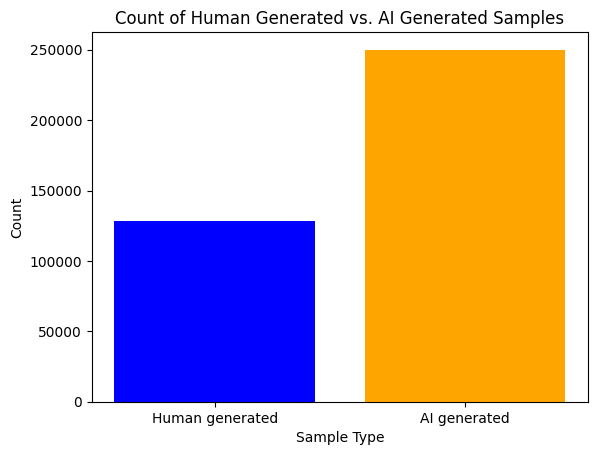

In [32]:
# Ttl_Hmn_dtst = 128293
# Ttl_AI_dtst = 250000
import matplotlib.pyplot as plt

# Data
categories = ['Human generated', 'AI generated']
counts = [128293, 250000]

# Create bar plot
plt.bar(categories, counts, color=['blue', 'orange'])

# Add labels and title
plt.xlabel('Sample Type')
plt.ylabel('Count')
plt.title('Count of Human Generated vs. AI Generated Samples')

# Show plot
plt.show()

### 3.2. Character Length Distribution 

In [33]:
# len(df_human_pcs['TEXT'][0])
chr_len_hmn = df_human_pcs['TEXT'].str.len()
chr_len_AI = df_AI_pcs['output'].str.len()

In [34]:
# chr_len_AI

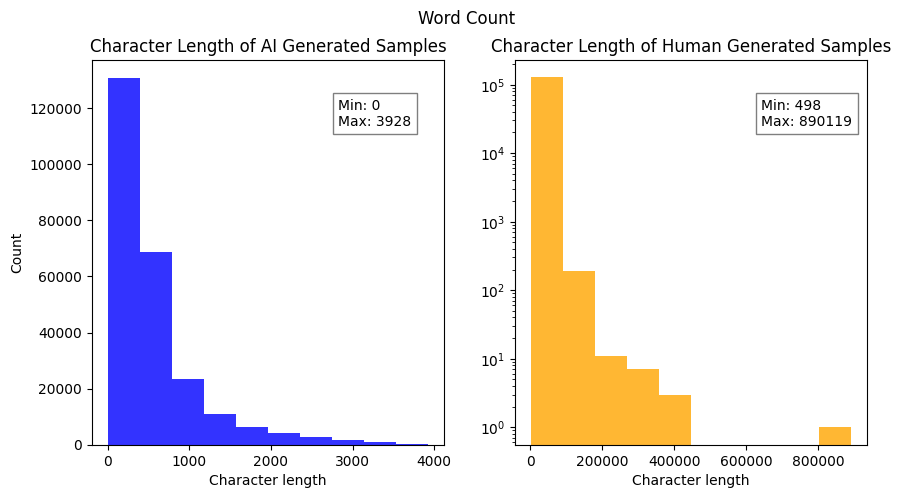

In [35]:
mn_cln_AI = min(chr_len_AI)
mx_cln_AI = max(chr_len_AI)
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
bin_vls,bins,_ = ax1.hist(chr_len_AI,bins=10,color='blue',alpha=0.8)
ax1.set_xlabel('Character length')
ax1.set_ylabel('Count')
ax1.set_title('Character Length of AI Generated Samples')
ax1.text(0.7, 0.9, f'Min: {mn_cln_AI}\nMax: {mx_cln_AI}', verticalalignment='top', horizontalalignment='left',
                                        transform=ax1.transAxes, bbox=dict(facecolor='white', alpha=0.5))
# plt.yscale('log')
# plt.show()
#
mn_cln_hmn = min(chr_len_hmn)
mx_cln_hmn = max(chr_len_hmn)
bin_vls,bins,_ = ax2.hist(chr_len_hmn,color='orange',alpha=0.8)
ax2.set_xlabel('Character length')
# ax2.set_ylabel('Count')
ax2.set_title('Character Length of Human Generated Samples')
ax2.text(0.7, 0.9, f'Min: {mn_cln_hmn}\nMax: {mx_cln_hmn}', verticalalignment='top', horizontalalignment='left',
                                        transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=0.5))
# plt.text(0.8, 0.8, f'Max: {mx_cln_hmn}', verticalalignment='top', horizontalalignment='left',
#                                     
#     transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
ax2.set_yscale('log')
plt.suptitle("Word Count")
plt.show()

### 3.3. Identify and Examine Null Values

In [36]:
# Checking the null values in AI prompts:
ind_zer = [i for i,x in enumerate(chr_len_AI) if chr_len_AI[i]==0]
ind_zer

len(df_AI_pcs['output'][4408])
print(df_AI_pcs['output'][4408])

df_AI.iloc[4408]['prompt']
df_AI.iloc[4408]

system    Below is an instruction that describes a task....
prompt    Given the task definition, example input & out...
output                                                     
Name: 4408, dtype: object

### 3.4. Word Count Distribution

In [37]:
num_wrds_hmn = df_human_pcs['TEXT'].str.split().map(lambda x: len(x))
num_wrds_AI = df_AI_pcs['output'].str.split().map(lambda x: len(x))

In [38]:
num_wrds_hmn.head()
num_wrds_AI.head()
len(num_wrds_AI)
len(num_wrds_hmn)
df_AI_pcs['output'][4]
# num_wrds_AI.head()

"The article does not provide the last name of the person who agreed to visit Britten's Aldeburgh Festival in 1959."

In [39]:
# len(num_wrds_hmn.tolist())
# human_word_count = num_wrds_hmn.tolist()
# ai_word_count = num_wrds_AI.tolist()
human_word_count = num_wrds_hmn
ai_word_count = num_wrds_AI

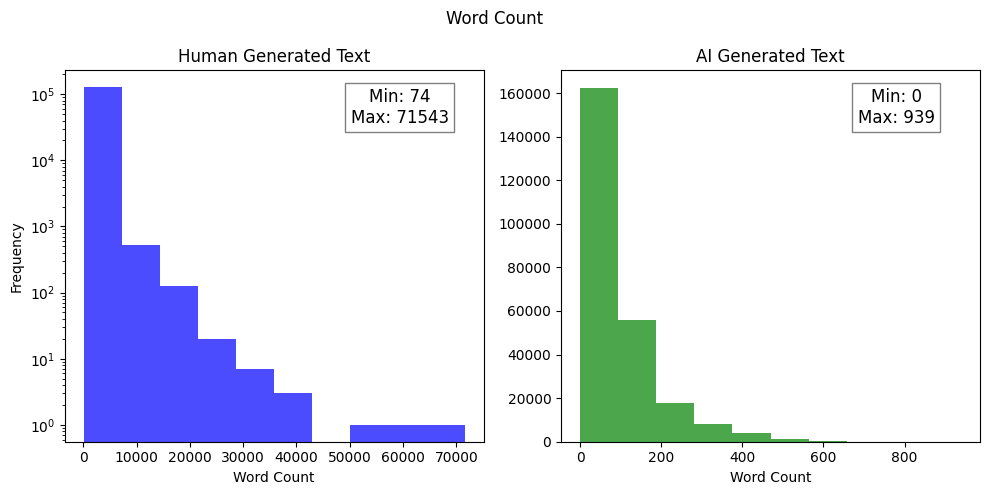

In [40]:
mn_wct_hmn = min(human_word_count)
mx_wct_hmn = max(human_word_count)
mn_wct_AI = min(ai_word_count)
mx_wct_AI = max(ai_word_count)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot histograms
ax1.hist(human_word_count, bins=10, color='blue', alpha=0.7)
ax2.hist(ai_word_count, bins=10, color='green', alpha=0.7)

# Set titles
ax1.set_title('Human Generated Text')
ax2.set_title('AI Generated Text')

# Set labels
ax1.set_xlabel('Word Count')
ax1.set_ylabel('Frequency')
ax2.set_xlabel('Word Count')
# ax2.set_ylabel('Frequency')

# Annotate human word count
ax1.text(0.8, 0.9, f'Min: {mn_wct_hmn}\nMax: {mx_wct_hmn}', horizontalalignment='center',
         verticalalignment='center', transform=ax1.transAxes, fontsize=12, color='black',bbox=dict(facecolor='white', alpha=0.5))

# # Annotate AI word count
ax2.text(0.8, 0.9, f'Min: {mn_wct_AI}\nMax: {mx_wct_AI}', horizontalalignment='center',
         verticalalignment='center', transform=ax2.transAxes, fontsize=12, color='black',bbox=dict(facecolor='white', alpha=0.5))

ax1.set_yscale('log')
plt.suptitle('Word Count')
plt.tight_layout()
plt.show()

In [41]:
### Average length of words per sample
# num_wrds_tst = df_human_pcs['TEXT'].str.split()
# num_wrds_AI = df_AI_pcs['output'].str.split()

In [42]:
# num_wrds_AI = df_AI_pcs['output'].str.split().apply(lambda x : [len(i) for i in x])
#stopping running because took more than 6 mins.

In [43]:
# word_hmn = num_wrds_tst.apply(lambda x : [len(i) for i in x])

### 3.5. Stop Words Analysis

In [44]:
# This function creates a list (corpus) of all words from a specified column in the given dataset.
def create_corpus(target,strng_in):
    corpus=[]
    
    # for x in df_human_pcs['TEXT'].str.split():
    for x in target[strng_in].str.split():
        for i in x:
            corpus.append(i)        
    return corpus

# for x in df_AI_pcs['output'].str.split():
#         for i in x:
#             corpus.append(i)

In [45]:
Corpus = create_corpus(df_human_pcs,'TEXT')

In [62]:
# pip install nltk

In [48]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jothimanithondiraj/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [49]:
stop

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [50]:
from collections import defaultdict
dic=defaultdict(int)
for word in Corpus:
    if word in stop:
        dic[word]+=1
        
top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

In [51]:
dic.items()
top

[('the', 11910099),
 ('of', 7090533),
 ('and', 5404345),
 ('to', 5320783),
 ('in', 3632299),
 ('a', 2877979),
 ('is', 2640826),
 ('that', 2467894),
 ('for', 1382061),
 ('as', 1375256)]

In [52]:
Corpus2 = create_corpus(df_AI_pcs,'output')
dic2=defaultdict(int)
for word in Corpus2:
    if word in stop:
        dic2[word]+=1
        
top2 = sorted(dic2.items(), key=lambda x:x[1],reverse=True)[:10] 

Text(0.5, 0.98, 'Stop Words')

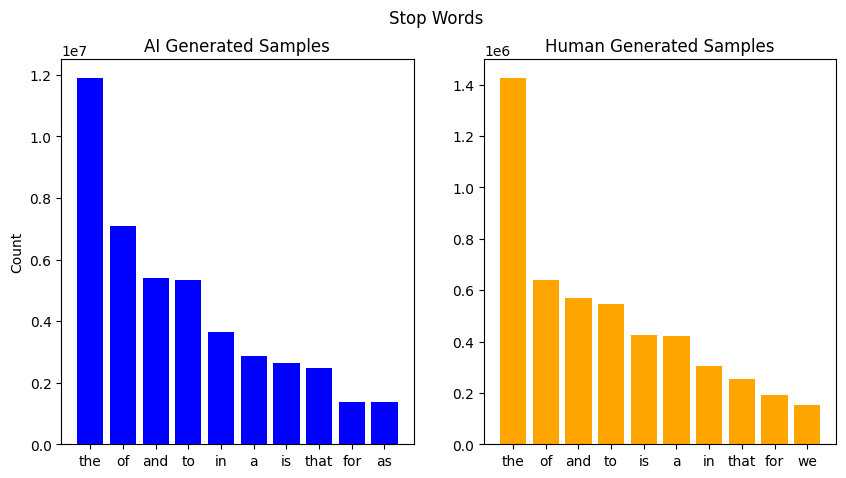

In [53]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
x,y=zip(*top)
ax1.bar(x,y,color='blue')
ax1.set_ylabel('Count')
ax1.set_title('AI Generated Samples')
x2,y2=zip(*top2)
ax2.bar(x2,y2,color='orange')
ax2.set_title('Human Generated Samples')
plt.suptitle("Stop Words")

### 3.6. Punctuations

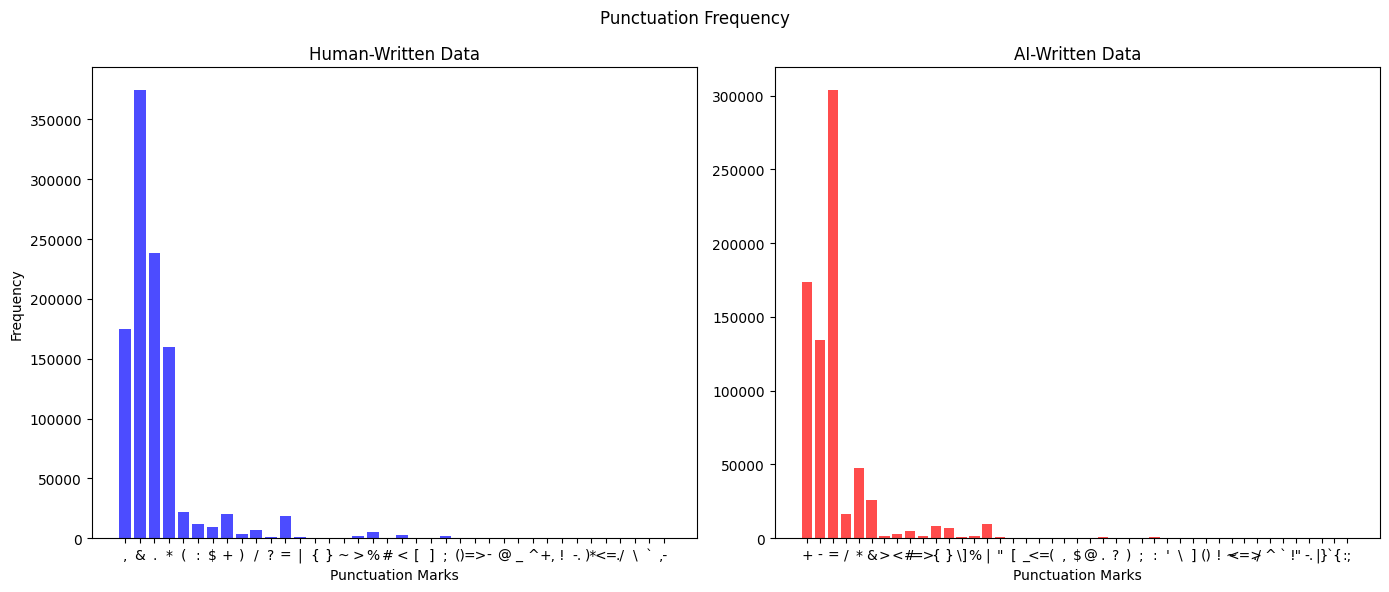

In [57]:
import matplotlib.pyplot as plt
from collections import defaultdict
import string

# Create dictionaries to count punctuation for human-written and AI-written data
dic_human = defaultdict(int)
dic_ai = defaultdict(int)
special = string.punctuation

# Count punctuation in human-written data
for i in Corpus:
    if i in special:
        dic_human[i] += 1

# Count punctuation in AI-written data
for i in Corpus2:
    if i in special:
        dic_ai[i] += 1

# Prepare data for plotting
x_human, y_human = zip(*dic_human.items())
x_ai, y_ai = zip(*dic_ai.items())

# Create subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plotting for human-written data
ax1.bar(x_human, y_human, color='blue', alpha=0.7)
ax1.set_xlabel('Punctuation Marks')
ax1.set_ylabel('Frequency')
ax1.set_title('Human-Written Data')

# Plotting for AI-written data
ax2.bar(x_ai, y_ai, color='red', alpha=0.7)
ax2.set_xlabel('Punctuation Marks')
ax2.set_title('AI-Written Data')
plt.suptitle("Punctuation Frequency")
# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [58]:
# dic=defaultdict(int)
# import string
# special = string.punctuation
# for i in (Corpus):
#     if i in special:
#         dic[i]+=1
        
# x,y=zip(*dic.items())
# plt.bar(x,y)

In [59]:
# dic=defaultdict(int)
# import string
# special = string.punctuation
# for i in (Corpus2):
#     if i in special:
#         dic[i]+=1
        
# x,y=zip(*dic.items())
# plt.bar(x,y,color='red')

### 3.7. Most Common Words

In [64]:
from collections import Counter

In [65]:
counter=Counter(Corpus)
most=counter.most_common()
x_c=[]
y_c=[]
for word,count in most[:40]:
    if (word not in stop) :
        x_c.append(word)
        y_c.append(count)
        

Text(0.5, 1.0, 'Human Written Text')

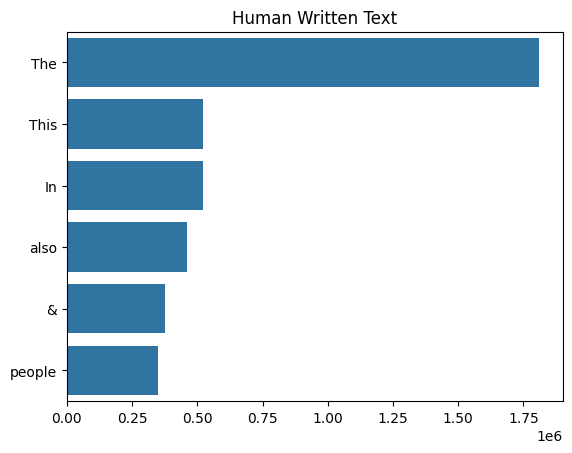

In [66]:
import seaborn as sns
sns.barplot(x=y_c,y=x_c)
plt.title("Human-Written Text")

In [67]:
counter=Counter(Corpus2)
most=counter.most_common()
x_c2=[]
y_c2=[]
for word,count in most[:40]:
    if (word not in stop) :
        x_c2.append(word)
        y_c2.append(count)        

Text(0.5, 1.0, 'AI-Written Text')

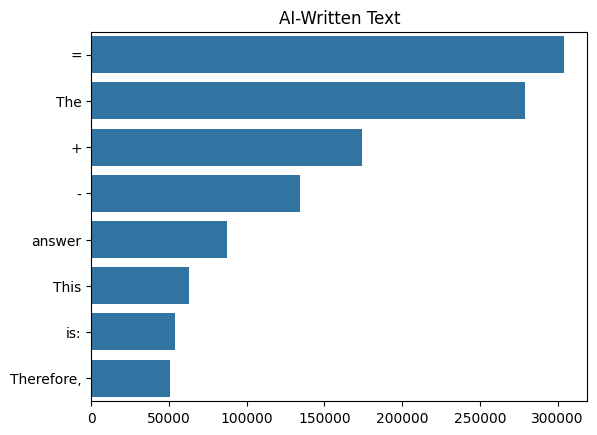

In [68]:
sns.barplot(x=y_c2,y=x_c2)
plt.title("AI-Written Text")

## 4. References

* https://www.kaggle.com/code/shahules/basic-eda-cleaning-and-glove#Loading-the-data-and-getting-basic-idea
* https://towardsdatascience.com/part-1-data-cleaning-does-bert-need-clean-data-6a50c9c6e9fd
* https://lejdiprifti.medium.com/ai-vs-human-detect-llm-generated-text-f5a55b5662bb
* https://chatgpt.com